In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from ava.models.vae_dataset import get_syllable_partition
from ava.models.vae_dataset import get_syllable_data_loaders

In [2]:
split = 0.8 # 80/20 train/test split
days = [36, 37, 140]

# Construct a random train/test partition.
spec_dirs = ['../audio_spec/%d' % _ for _ in days]
partition = get_syllable_partition(spec_dirs, split)
# clip_dirs = ['../audio_clips/%d' % _ for _ in days]
# partition = get_syllable_partition(clip_dirs, split)

# Make Dataloaders.
loaders = get_syllable_data_loaders(partition, batch_size=128)

In [3]:
for i, spec in enumerate(loaders['test']):
    # spec = spec[:,:,5:-5]
    print(spec.shape)
    break # just to get a slice
sample = spec.numpy()

torch.Size([128, 50, 20])


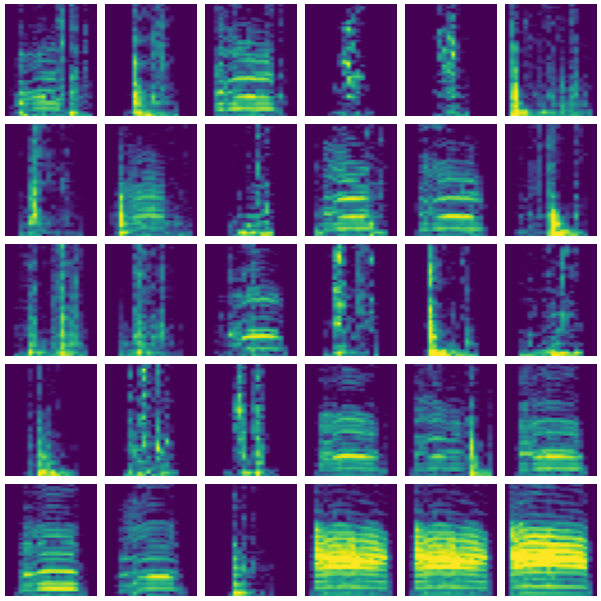

In [4]:
%matplotlib inline
fig, ax = plt.subplots(5, 6, figsize=(6,6), sharex='all', sharey='all')
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(sample[i], aspect='auto', origin='lower')
    # # ax[i].plot(sample[i].numpy())
    # f, t, sxx = stft(sample[i].numpy(), fs=8820, nperseg=128, noverlap=64)
    # sxx = np.log(np.abs(sxx) + 1e-12)
    # sxx = (sxx - 3) / 5
    # sxx = np.clip(sxx, 0, 1)
    # ax[i].imshow(sxx, aspect='auto')
    ax[i].set_axis_off()
plt.show()

In [5]:
act_func = lambda x: torch.log(1+x**2)
# act_func = lambda x: torch.tanh(x)
class audioNet(nn.Module):
    def __init__(self, output_dim, kernel_dims, pad, stride):
        super(audioNet, self).__init__()
        self.w1 = nn.Conv2d(in_channels=1, out_channels=output_dim, 
                            kernel_size=kernel_dims, padding=pad, 
                            stride=stride, bias=False)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1) # first dim is batch
        y = act_func(self.w1(x))
        return y

In [6]:
net = audioNet(100, (25,16), pad=(0,0), stride=(5,1))
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-5)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)

EPOCH = 20
train_loss, test_loss = [], []

In [7]:
def loss_func(out):
    # out: (batch_size, kernel_size, kernel_spec_dim, kernel_time_dim)
    L2_sample = torch.sqrt((out**2).sum(dim=(0,3), keepdim=True))
    out = out / L2_sample
    L2_feature = torch.sqrt((out**2).sum(dim=(1,2), keepdim=True))
    out = out / L2_feature
    L1_all = torch.abs(out).mean()
    return L1_all

In [8]:
for epoch in range(EPOCH):
    aux_train_loss = []
    for spec in tqdm(loaders['train']):
        spec += torch.normal(0, 0.05, size=spec.shape)
        # spec = (spec - spec.mean(dim=(1,2), keepdim=True))
        optimizer.zero_grad()
        out = net(spec)
        loss = loss_func(out)
        
        aux_train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    train_loss.append(aux_train_loss)
    
    with torch.no_grad():
        aux_test_loss = []
        for i, spec in enumerate(loaders['test']):
            # spec = (spec - spec.mean(dim=(1,2), keepdim=True))
            if i > 50:
                break
            out = net(spec)
            loss = loss_func(out)
            aux_test_loss.append(loss.item())
        test_loss.append(aux_test_loss)
    
    print('[%d] Train loss = %.3E, Test loss = %.3E' % \
          (epoch, np.mean(aux_train_loss), np.mean(aux_test_loss)))

100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 77.04it/s]


[0] Train loss = 2.087E-02, Test loss = 1.822E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 78.11it/s]


[1] Train loss = 1.760E-02, Test loss = 1.629E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 75.50it/s]


[2] Train loss = 1.606E-02, Test loss = 1.515E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 76.54it/s]


[3] Train loss = 1.502E-02, Test loss = 1.435E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 73.48it/s]


[4] Train loss = 1.430E-02, Test loss = 1.377E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 73.16it/s]


[5] Train loss = 1.378E-02, Test loss = 1.331E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 75.41it/s]


[6] Train loss = 1.333E-02, Test loss = 1.296E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 72.02it/s]


[7] Train loss = 1.301E-02, Test loss = 1.266E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 72.55it/s]


[8] Train loss = 1.274E-02, Test loss = 1.245E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 74.24it/s]


[9] Train loss = 1.256E-02, Test loss = 1.226E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 71.81it/s]


[10] Train loss = 1.240E-02, Test loss = 1.214E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 71.86it/s]


[11] Train loss = 1.228E-02, Test loss = 1.200E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 72.85it/s]


[12] Train loss = 1.216E-02, Test loss = 1.190E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 73.05it/s]


[13] Train loss = 1.207E-02, Test loss = 1.179E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 72.56it/s]


[14] Train loss = 1.203E-02, Test loss = 1.172E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 73.27it/s]


[15] Train loss = 1.198E-02, Test loss = 1.170E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 74.13it/s]


[16] Train loss = 1.188E-02, Test loss = 1.164E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 70.93it/s]


[17] Train loss = 1.189E-02, Test loss = 1.159E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 72.48it/s]


[18] Train loss = 1.183E-02, Test loss = 1.157E-02


100%|█████████████████████████████████████████| 203/203 [00:02<00:00, 72.28it/s]


[19] Train loss = 1.176E-02, Test loss = 1.155E-02


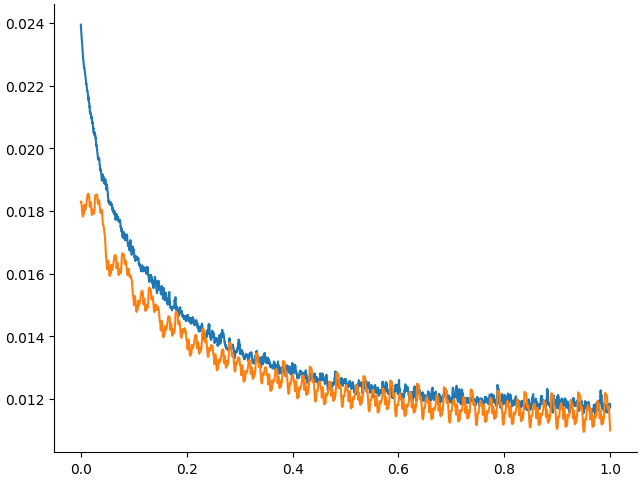

In [9]:
%matplotlib inline
train_loss, test_loss = np.hstack(train_loss), np.hstack(test_loss)
train_loss = np.convolve(train_loss, np.ones(10)/10)[11:-11]
test_loss = np.convolve(test_loss, np.ones(10)/10)[11:-11]
plt.plot(np.linspace(0,1,num=len(train_loss)), train_loss)
plt.plot(np.linspace(0,1,num=len(test_loss)), test_loss)

In [10]:
torch.save(net.state_dict(), 'net_params.pkl')

-0.19388899 0.13630126


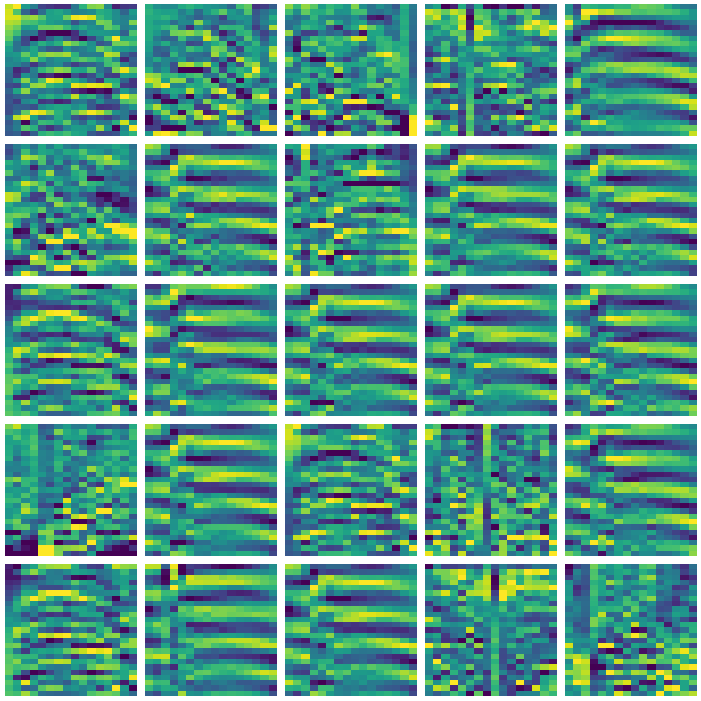

In [11]:
%matplotlib inline
fig, ax = plt.subplots(5, 5, figsize=(7,7), sharex='all', sharey='all')
ax = ax.flatten()
w1 = np.squeeze(net.w1.weight.data.numpy())
print(w1.min(), w1.max())
w1 = (w1 - w1.mean(axis=1)[:,None]) / w1.std(axis=1)[:,None]
for i in range(len(ax)):
    ax[i].imshow(w1[i], vmin=-2, vmax=2, 
                 aspect='auto', origin='lower')
    ax[i].set_axis_off()
plt.show()

0.013728019781410694
(128, 100, 6, 5)


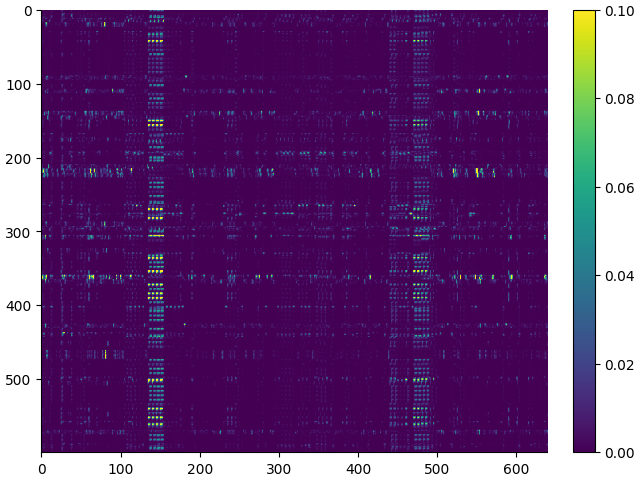

In [12]:
# x = sample - sample.mean(axis=(1,2),keepdims=True)
x = sample
y = net(torch.tensor(x)).detach()
print(loss_func(y).item())
y = y.numpy()
print(y.shape)
# each list item is an (kernel_size*kernel_spec_dim, kernel_time_dim) array
y = [np.vstack(y[i]) for i in range(y.shape[0])] 
# then hstack
y = np.hstack(y) # (kernel_size*kernel_spec_dim, kernel_time_dim*sample_size)
plt.imshow(y, vmin=0, vmax=0.1, aspect='auto')
plt.colorbar()